# Music Generator with LSTM

## About

Music resamples language as a temporal sequence of articulated sounds. They say something, often something human.

Although, there are crucial differences between language and music. We can still describe it as a sequence of symbols in the simplest form of understanding. Translating something complex into something simpler, but usable by computational models.

Thus, the objective of this project is to establish a communication between the human, that understands music in the most intense way that the brain can interpret through information, and the machine.

We'll create a model that can generate music based on the input information, i.e., generate a sequence of sounds which are related in some way with the sounds passed as input.

We'll use Natural Language Processing (NLP) methods, observing the music as it were a language, abstracting it. Doing this, the machine can recognize and process similar data.

On the first step, we'll use text generation techniques, using Recurrent Neural Networks (RNNs) and Long-Short Term Memories (LSTMs). With the effectiveness of the training, even if it's reasonable, we'll perform the same implementation using specific methods such as Attention.



## Imports and environment configuration

In [ ]:
!pip install music21
!pip install pickle
!pip install fastprogress



ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
# Basic libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocessing data libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data visualization
from torch.utils.tensorboard import SummaryWriter
from fastprogress.fastprogress import master_bar, progress_bar

# Utils
import music21
import pickle

%matplotlib inline
# music21.configure.run()
import notebook

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [ ]:
from encoder import *
from decoder import *

## Dataset

### Load data

In [ ]:
data_path = '../data/'
out_encoded_path = '../encoded/'
out_decoded_path = '../decoded/'
models_path = '../models/'

filename = 'All I Have To Do Is Dream'
in_file = data_path + filename

out_encoded = out_encoded_path + filename
out_decoded = out_decoded_path + filename

N_FRAMES = 36
N_NOTES = 88
MIDI_OFFSET = 20

In [ ]:
# be sure that the dirs exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(out_encoded_path, exist_ok=True)
os.makedirs(out_decoded_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [ ]:
# get encoded data and save encoded file
encoded_song = encode_data(in_file,
                           N_FRAMES,
                           N_NOTES,
                           MIDI_OFFSET, 
                           save_as=out_encoded
                           )

Encoding file All_i_have_to_do_is_dream


{0.0} <music21.stream.Part 0x7f3fcd06f0a0>
    {0.0} <music21.instrument.Bass 'Bass: Bass'>
    {0.0} <music21.tempo.MetronomeMark maestoso Quarter=90.0>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest rest>
    {1.0} <music21.instrument.AcousticBass 'Acoustic Bass'>
    {1.0} <music21.note.Rest rest>
    {8.0} <music21.note.Note E->
    {9.0} <music21.note.Rest rest>
    {9.5} <music21.note.Note E->
    {10.0} <music21.note.Note C>
    {11.25} <music21.note.Rest rest>
    {11.5} <music21.note.Note C>
    {12.0} <music21.note.Note G#>
    {13.0} <music21.note.Rest rest>
    {13.5} <music21.note.Note G#>
    {14.0} <music21.note.Rest rest>
    {14.25} <music21.note.Note B->
    {15.0} <music21.note.Note C>
    {15.5} <music21.note.Note B->
    {16.0} <music21.note.Note E->
    {17.0} <music21.note.Rest rest>
    {17.5} <music21.note.Note E->
    {18.0} <music21.note.Note C>
    {19.0} <music21.note.Rest rest>
    {19.5} <mu

Encoding Piano


Encoding Sampler


Encoding Electric guitar


Encoding Stringinstrument


Encoding Voice 2


Took 12.464607954025269


## Data visualization

Each song is represented by a Pandas DataFrame where each column represents some song status. 

### DataFrame Representation

In [ ]:
encoded_song

,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Voice,52,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice,52,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice,52,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice,52,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice,52,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Voice 2,54,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice 2,54,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Voice 2,54,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## List of instruments

In [ ]:
instruments = list(set(encoded_song.index))
instruments

['Voice', 'Sampler', 'Voice 2', 'Stringinstrument', 'Electric guitar', 'Piano']

### Let's get the Sampler from that song

Number of frames: 2052
Number of bars: 57


,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sampler,82,C,90,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


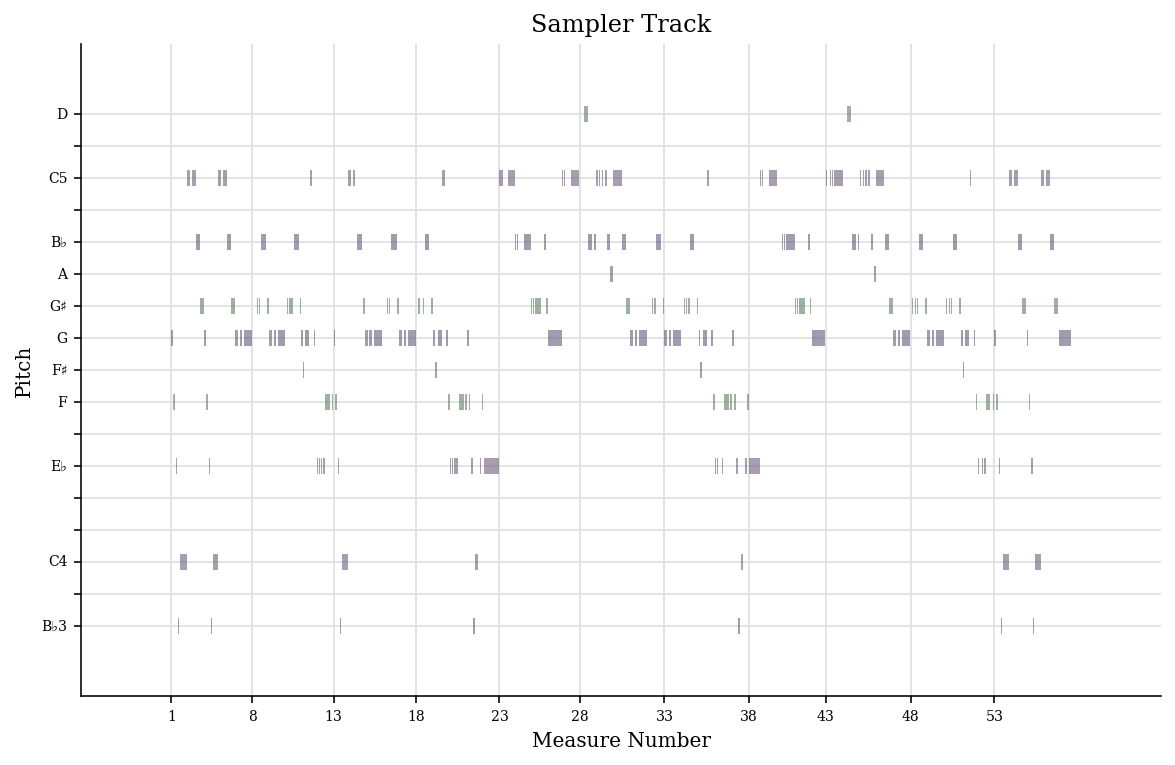

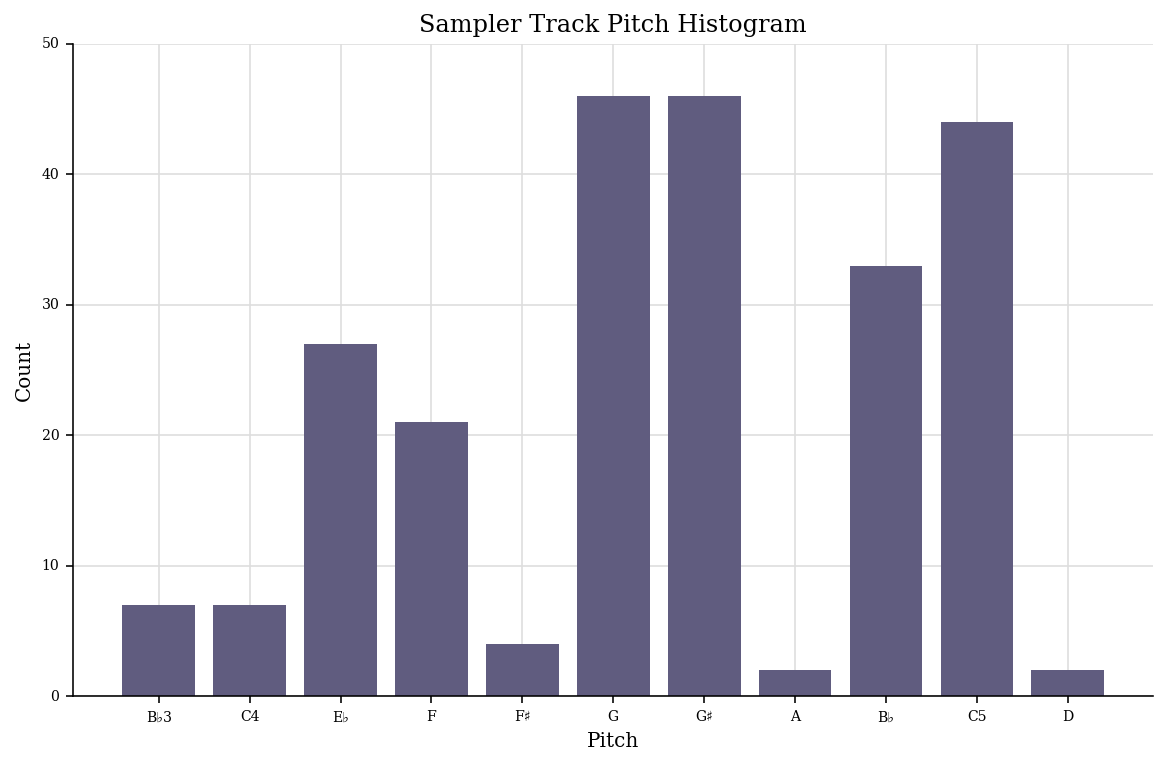

In [ ]:

sampler_df = encoded_song[encoded_song.index=='Sampler']

print(f'Number of frames: {len(sampler_df.index)}')
print(f'Number of bars: {len(sampler_df.index)//N_FRAMES}')

sampler = decode_part(sampler_df, 'Sampler', 82, N_FRAMES)
# sampler = decode_data(sampler_df, N_FRAMES)

sampler.plot(title='Sampler Track')
sampler.plot('histogram', 'pitchSpace', title='Sampler Track Pitch Histogram')

# sampler.show('midi')

sampler_df

### Preprocess data

In [ ]:
def get_stackframe(encoded_song, init_idx, final_idx, to_float=True):
    stackframe = encoded_song.iloc[init_idx:final_idx, 4:]
    stackframe = stackframe.to_numpy()

    # print(f'Stackframe shape: {stackframe.shape}')
    if to_float:
        stackframe.astype(float)
        stackframe = stackframe + 0.0

    return stackframe

In [ ]:
def get_info(encoded_song, num_frames=N_FRAMES):
    infos = encoded_song.iloc[:num_frames, 0:4]
    return infos

In [ ]:
sampler_info = get_info(sampler_df, len(sampler_df))

In [ ]:
import os
def create_dataset(root_dir, instrument, n_frames=N_FRAMES):
    dataset = []
    for filename in os.listdir(root_dir):
        if filename.endswith('pkl'):
            infile = open(root_dir + filename,'rb')
            encoded_song = pickle.load(infile)
            infile.close()
            encoded_part = encoded_song[encoded_song.index==instrument]
            
            init_idx = 0
            final_idx = len(encoded_part)
            stackframe = get_stackframe(encoded_part, init_idx=init_idx, final_idx=final_idx)
            dataset.append(np.array(stackframe))
      
    return dataset

### Create a dataset with all Sampler streams in a directory

In [ ]:
root_dir = '../encoded/'
instrument = 'Sampler'

dataset = create_dataset(root_dir, instrument)
print(f'Dataset size: {len(dataset)} song(s)')
dataset

Dataset size: 1 song(s)


[array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)]

In [ ]:
def split_dataset(dataset, n_frames=N_FRAMES):
    X = []
    y = []
    
    # create two arrays X, y with bars
    for song in dataset:
        # create the frame blocks shifted in one position
        for i in range(song.shape[0] - n_frames):
            j = i + n_frames
            xa = song[i:j]
            ya = song[i+1:j+1]
            X.append(xa)
            y.append(ya)
        
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='float64')
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    print(f'X.shape, y.shape: {X.shape, y.shape}')
    train_ds = TensorDataset(X, y) # (X, y)
    return train_ds

### Prepare training data: DataSet & DataLoader

In [ ]:
train_ds = split_dataset(dataset)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=False)

X.shape, y.shape: (torch.Size([2016, 36, 88]), torch.Size([2016, 36, 88]))


## Model

### Utility and hyperparemeters definitions

In [ ]:
windows_size = N_FRAMES
keyboard_size = N_NOTES


hidden_size = windows_size
num_layers = 4
num_epochs = 3
batch_size = 1
lr = 3e-4

N_EPOCHS = 80

n_bars_input = len(train_dl.dataset.tensors[0]) # number of rows of the dataloader
print('Number of bars in the input dataset: {}'.format(n_bars_input))

Number of bars in the input dataset: 2016


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #self.embed = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional=True)
    self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
    self.fc2 = nn.Linear(hidden_size*2, output_size)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus(beta=500, threshold=0)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, hidden, cell):

    # Passing in the input and hidden state into the model and obtaining outputs
    out, (hidden, cell) = self.lstm(x.unsqueeze(1), (hidden, cell))

    # Reshaping the outputs such that it can be fit into the fully connected layer
    #print(torch.squeeze(out[-1]))
    out = out.contiguous().view(-1, self.hidden_size*2)
    #print('Shape2: ',out.shape)
    # out = self.fc1(out)
    #print('Shape3: ',out.shape)
    # out = self.softplus(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    # This method generates the first hidden state of zeros which we'll use in the forward pass
    # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(device)
    return hidden, cell

In [ ]:
# Instantiate the model with hyperparameters
# We'll also set the model to the device that we defined earlier (default is CPU)
model = RNN(input_size=keyboard_size,
                   output_size=keyboard_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers).to(device)

In [ ]:
print(model)


RNN(
  (lstm): LSTM(88, 36, num_layers=4, bidirectional=True)
  (fc1): Linear(in_features=72, out_features=72, bias=True)
  (fc2): Linear(in_features=72, out_features=88, bias=True)
  (relu): ReLU()
  (softplus): Softplus(beta=500, threshold=0)
  (sigmoid): Sigmoid()
)


## Train

In [ ]:
# converts one frame into torch tensor
def multi_hot_tensor(frame):
  tensor = torch.from_numpy(frame)
  return tensor

In [ ]:
def train(model, optimizer, loss_fn, dataloader, batch_size=1, num_epochs=3):
    writer = SummaryWriter()

    print("[Train Starting]")

    mb = master_bar(range(1, num_epochs+1))
    mb.names = ['Loss', 'FrameBlock']
    train_loss = []

    for epoch_index in mb:
        count = 0
        training_loss = 0.0

        input, target = get_sample(dataloader)
        input = input.to(device)
        target = target.to(device)
        
        # Initialize hidden and cells
        hidden, cell = model.init_hidden(batch_size)

        n_frameblocks = len(train_dl.dataset.tensors[0])

        for frameblock_index in progress_bar(range(n_frameblocks), parent=mb):

            # Generate predictions
            frameblock = input[frameblock_index,:]
            output, (hidden, cell) = model(frameblock, hidden, cell)
            

            # Compute the loss and backpropag
            loss_step = loss_fn(output, target[frameblock_index, :])

            hidden = hidden.detach()
            cell = cell.detach()

            count += 1

            loss_step.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            optimizer.zero_grad() # Clears existing gradients from previous frame

            training_loss += loss_step.item()

            # each 200 frameblocks
            if frameblock_index % 200 == 0:
                mb.child.comment = f'Loss {training_loss:.8f}'

        training_loss /= len(train_dl.dataset)
        writer.add_scalar("Loss/train", training_loss, epoch_index)

        train_loss.append(training_loss)
        mb.main_bar.comment = f'Loss {training_loss:.8f}'
        plot_loss_update(epoch_index, num_epochs, mb, train_loss)

    writer.flush()
    writer.close()

In [ ]:
# retrieve data from dataloader
def get_sample(dataloader):

  input = torch.zeros(n_bars_input, windows_size, keyboard_size)
  target = torch.zeros(n_bars_input, windows_size, keyboard_size)

  for sample, (xb, yb) in enumerate(dataloader): # gets the samples
    input[sample] = xb
    target[sample] = yb
  
  return input, target

In [ ]:
def plot_loss_update(epoch, epochs, mb, train_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = train_loss
    graphs = [[x,train_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)

### Load model (if exist)

In [ ]:
# comment if necessary
# model = torch.load(f'{models_path}model_{filename}_{N_EPOCHS}_epochs.pt')

### Train model

[Train Starting]


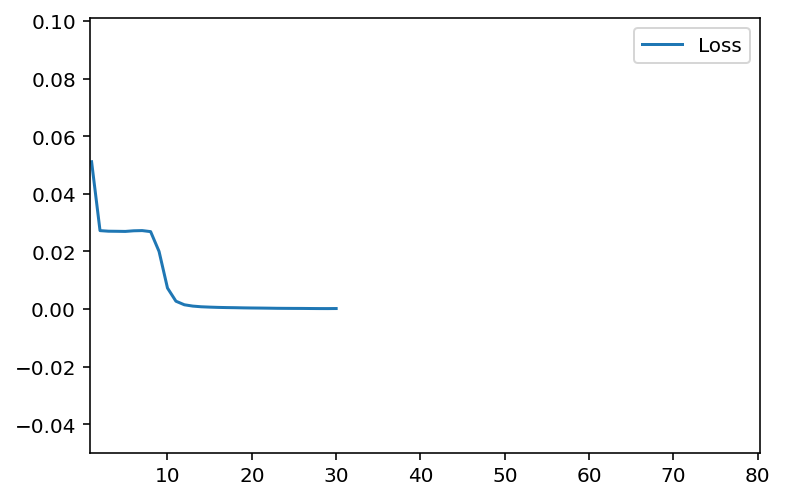

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# !jupyter nbextension enable --py widgetsnbextension
train(model, optimizer, loss_fn, train_dl, num_epochs=N_EPOCHS)

torch.save(model, f'{models_path}model_{filename}_{N_EPOCHS}_epochs.pt')

In [ ]:
# print(loss_fn())
# !tensorboard --logdir=runs


### USADO PRA ALGO??????

dict_idx = {i: column for i, column in enumerate(sampler_df.columns[4:])}
dict_note = {column: i for i, column in enumerate(sampler_df.columns[4:])}

## Test

In [ ]:
def unroll_bars(bars, n_frames=N_FRAMES):

    output = []
    init_idx = 0
    final_idx = len(bars)
    stackframe = get_stackframe(bars, init_idx=init_idx, final_idx=final_idx)

    return np.array(stackframe, dtype='float64')

In [ ]:
# TODO: Be able to especify the number of measures to predict!

@torch.no_grad()
def generate(model, previous_bars, n_frames=N_FRAMES, temperature=0.5, batch_size=1):
    hidden, cell = model.init_hidden(batch_size)

    unrolled = torch.from_numpy(
                    unroll_bars(previous_bars, n_frames)
    ).float().to(device)


    # amount of frameblocks in the context input
    context_fb_n = len(unrolled) - n_frames

    # getting context iterating over
    # N-1 of the frameblocks

    for i in range(context_fb_n):
        context_fb = unrolled[i:i + n_frames]

        # we dont care about the output here.
        # we are just feeding the model with the
        # context we received as input
        _, (hidden, cell) = model(context_fb,
                                  hidden, cell)

    # we must get the output from the last context fb
    last_fb = unrolled[context_fb_n:]
    out, (hidden, cell) = model(last_fb, hidden, cell)
    
    # generate the other remaining frames
    for i in range(n_frames - 1):
      out = torch.where(out >= (1-temperature), 1, 0).float()
      out, (hidden, cell) = model(out, hidden, cell)

    # print(out)
    out = np.where(out.cpu() >= (1-temperature), True, False)

    # print(out, out.shape)
    return out

In [ ]:
def create_decoded_song(bars, infos):
    num_bars = bars.shape[0]
    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bars.shape[2])]
    df_decoded_song = pd.DataFrame([], columns=columns)
    
    for idx_bar in range(num_bars):
        indexes = [infos.index[0] for i in range(bars[idx_bar].shape[0])]
        df_decoded_bar = pd.DataFrame(bars[idx_bar], columns=columns).set_index(pd.Index(indexes)) 
        df_decoded_song = df_decoded_song.append(df_decoded_bar) 

    df_decoded_song.index.name = 'inst'
    output = pd.concat([infos, df_decoded_song], axis=1)
    return output

In [ ]:
def create_decoded_bar(bar, infos):

    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bar.shape[1])]

    indexes = [infos.index[0] for i in range(bar.shape[0])]
    df_decoded_bar = pd.DataFrame(bar, columns=columns).set_index(pd.Index(indexes))
    df_decoded_bar.index.name = 'inst'
    print(infos.shape, df_decoded_bar.shape)
    output = pd.concat([infos, df_decoded_bar], axis=1)
    return output


## Previous

Decoding instrument: Sampler


Took 2.211986541748047
Decoding instrument: Sampler
Took 0.16002917289733887
Decoding instrument: Sampler


Took 2.2454426288604736


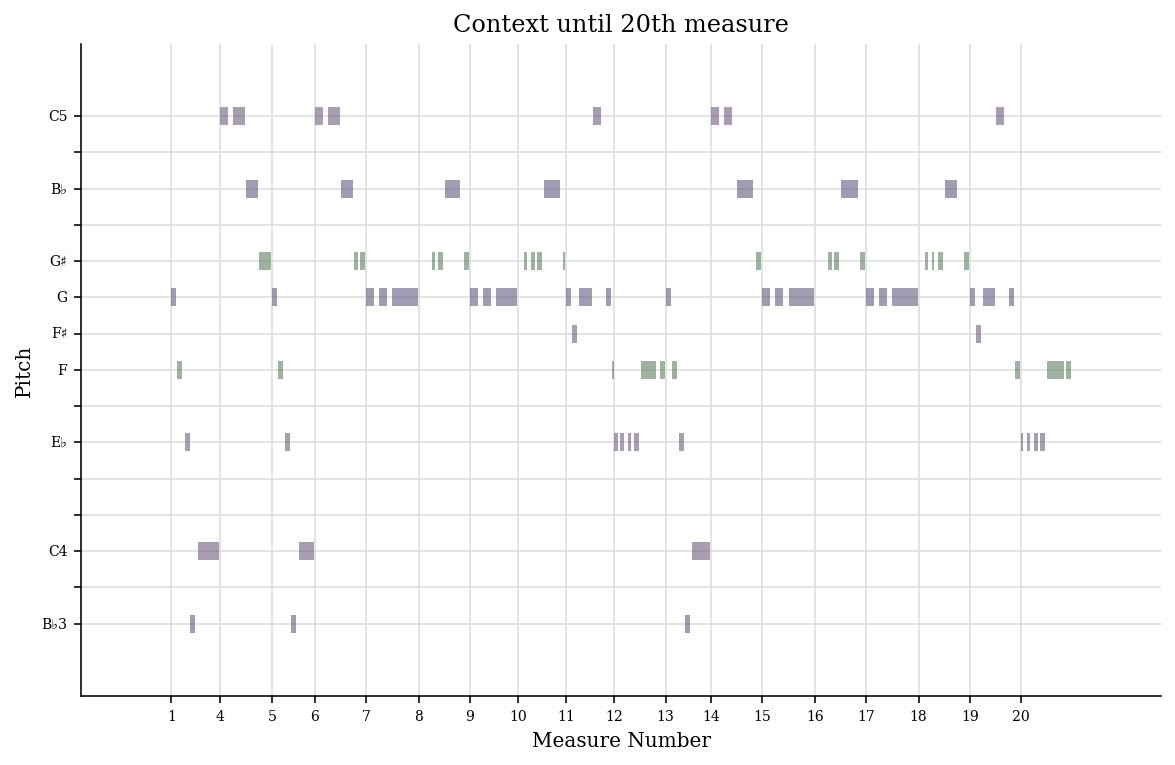

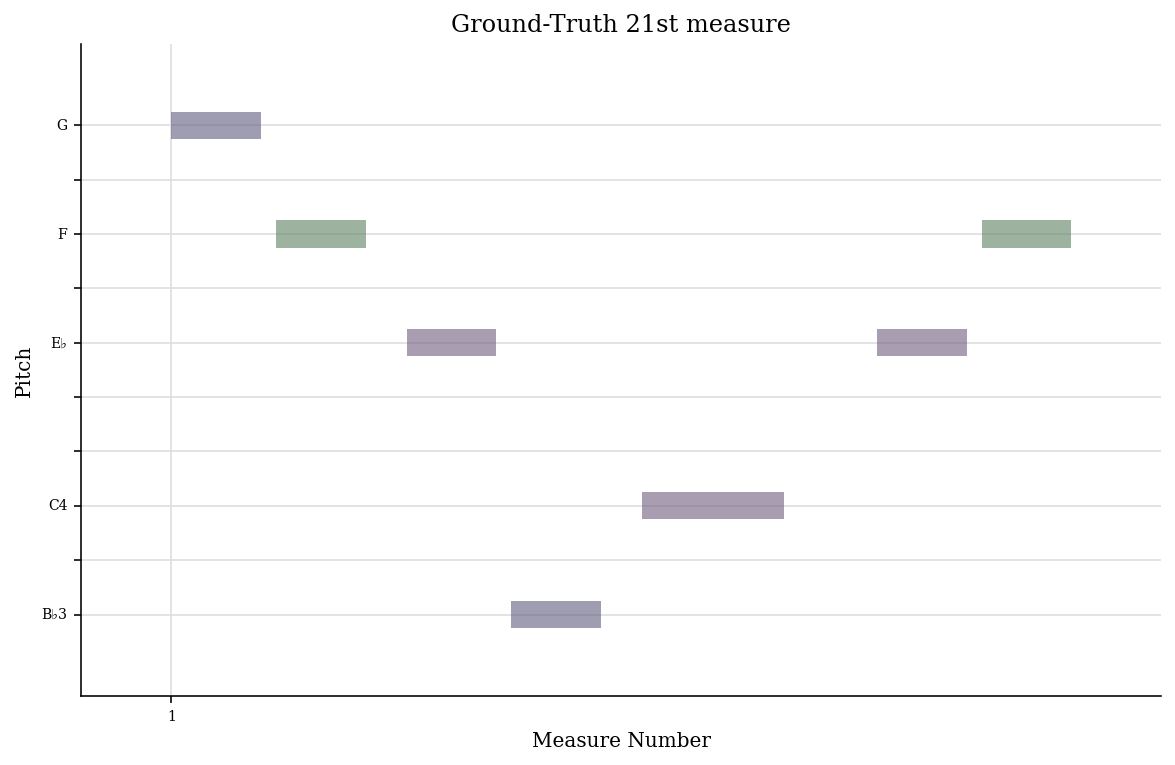

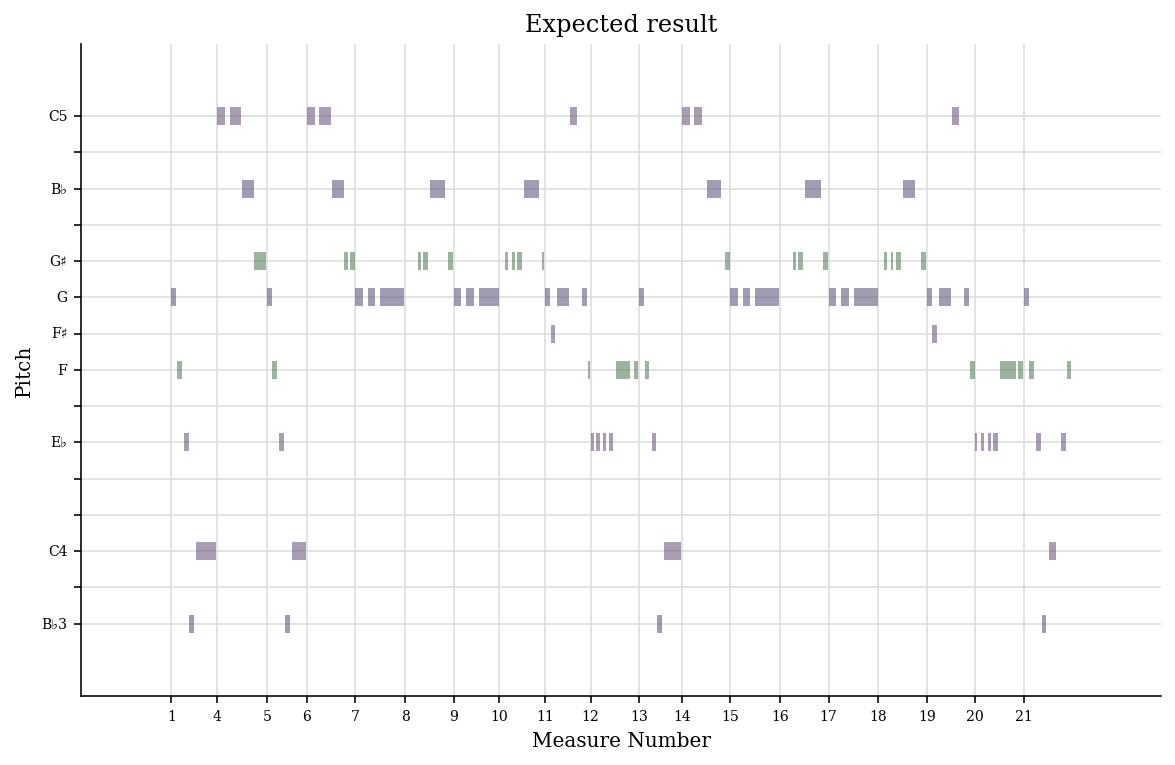

In [ ]:
first = 0
last = 20 # 20th


ground = 21 # 21st

context_df = sampler_df.iloc[first:N_FRAMES*last]
context = decode_data(context_df, N_FRAMES)

groud_truth_df = sampler_df.iloc[last*N_FRAMES:ground*N_FRAMES]
groud_truth = decode_data(groud_truth_df, N_FRAMES)

expected_df = pd.concat([context_df, groud_truth_df], axis=0)
expected = decode_data(expected_df, N_FRAMES)


context.plot(title='Context until 20th measure')
groud_truth.plot(title='Ground-Truth 21st measure')
expected.plot(title='Expected result')

## Gerating Output

(36, 4) (36, 88)
Decoding instrument: Sampler
Took 0.13791370391845703


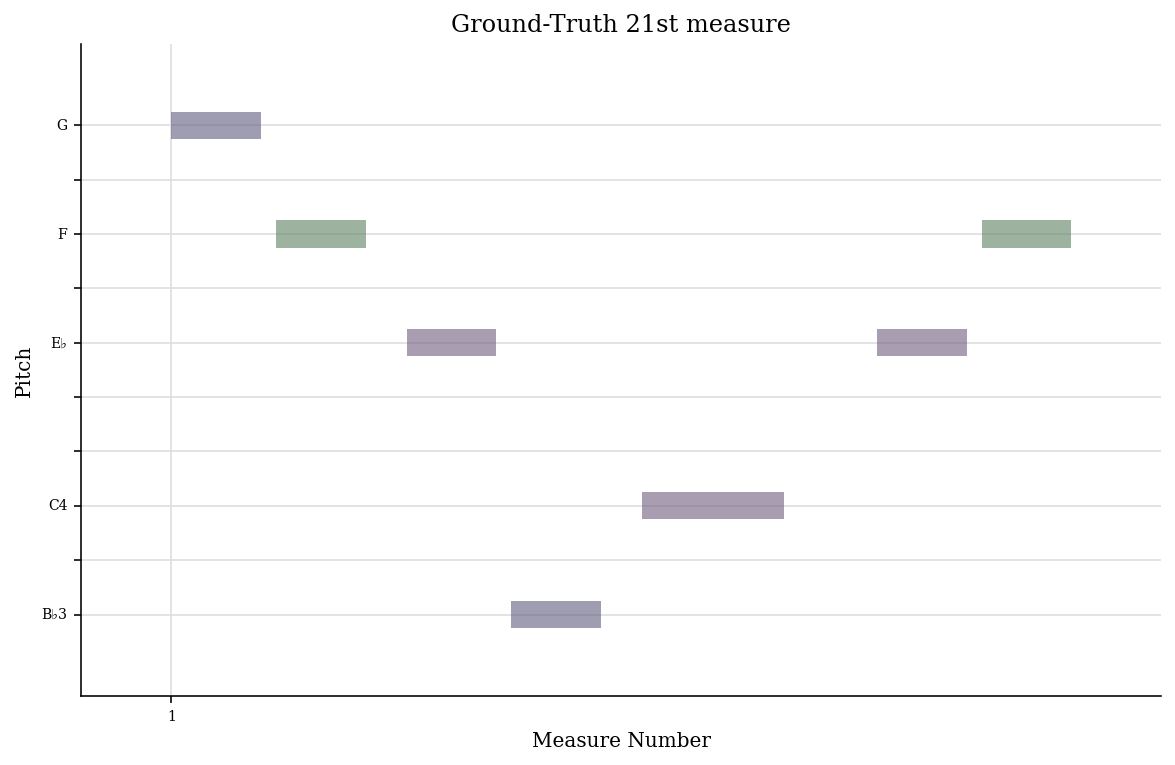

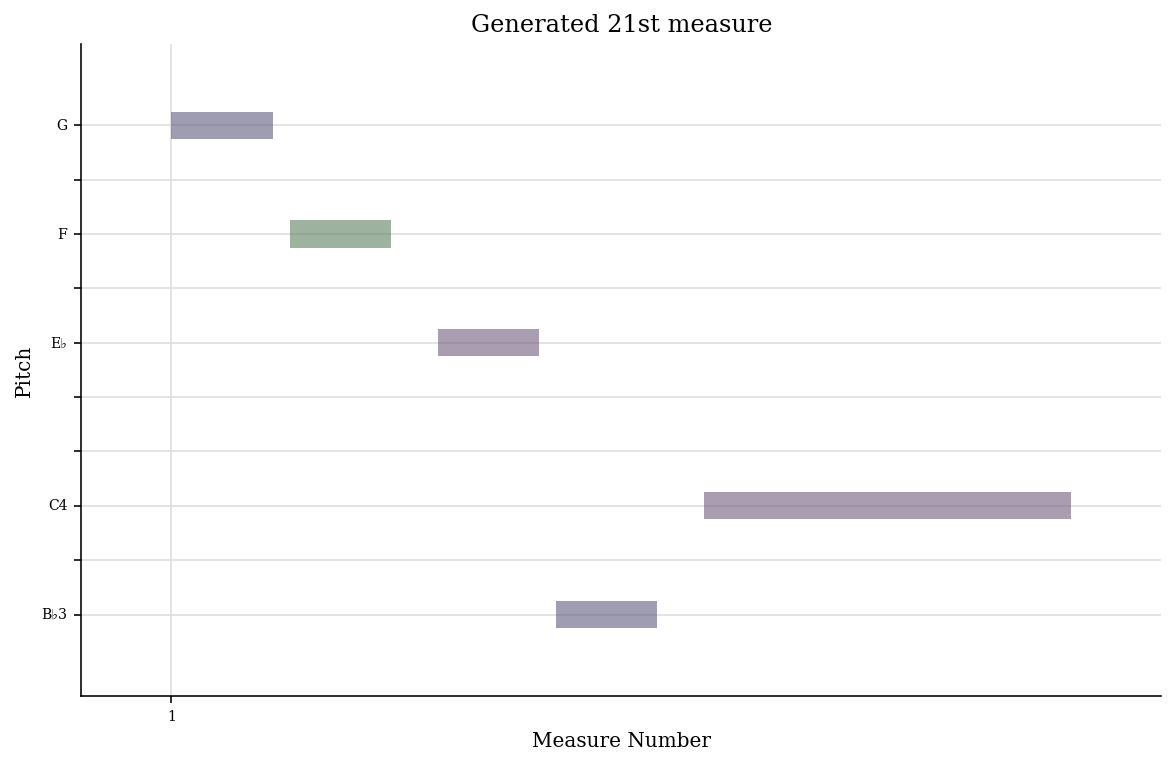

In [ ]:
# temperate=0.2 ---> predicted probability >= 80%
output_multi_hot = generate(model, context_df, N_FRAMES, temperature=0.2)
output_info = get_info(groud_truth_df, N_FRAMES)

generated_df = create_decoded_bar(output_multi_hot, output_info)
generated = decode_data(generated_df, N_FRAMES)

try:
        groud_truth.plot(title='Ground-Truth 21st measure')
        generated.plot(title='Generated 21st measure')
except Exception as e: print(e)

## Comparating generated with expected

Decoding instrument: Sampler


Took 2.420710325241089


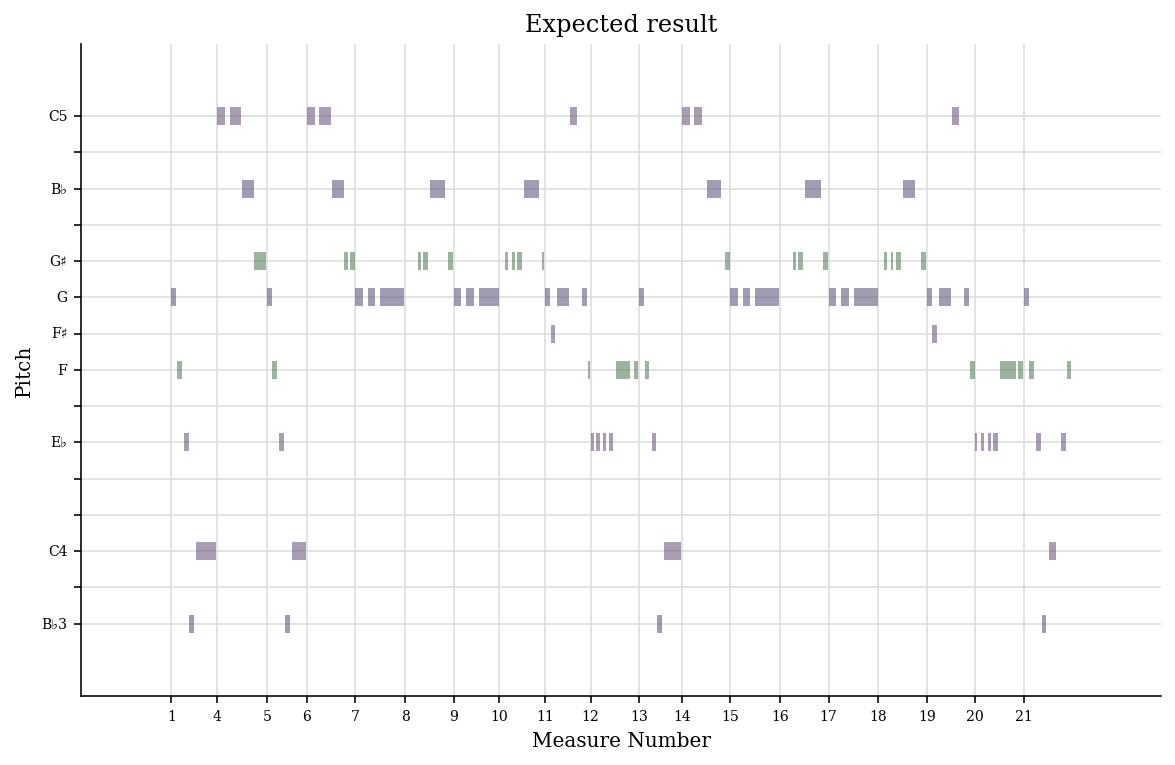

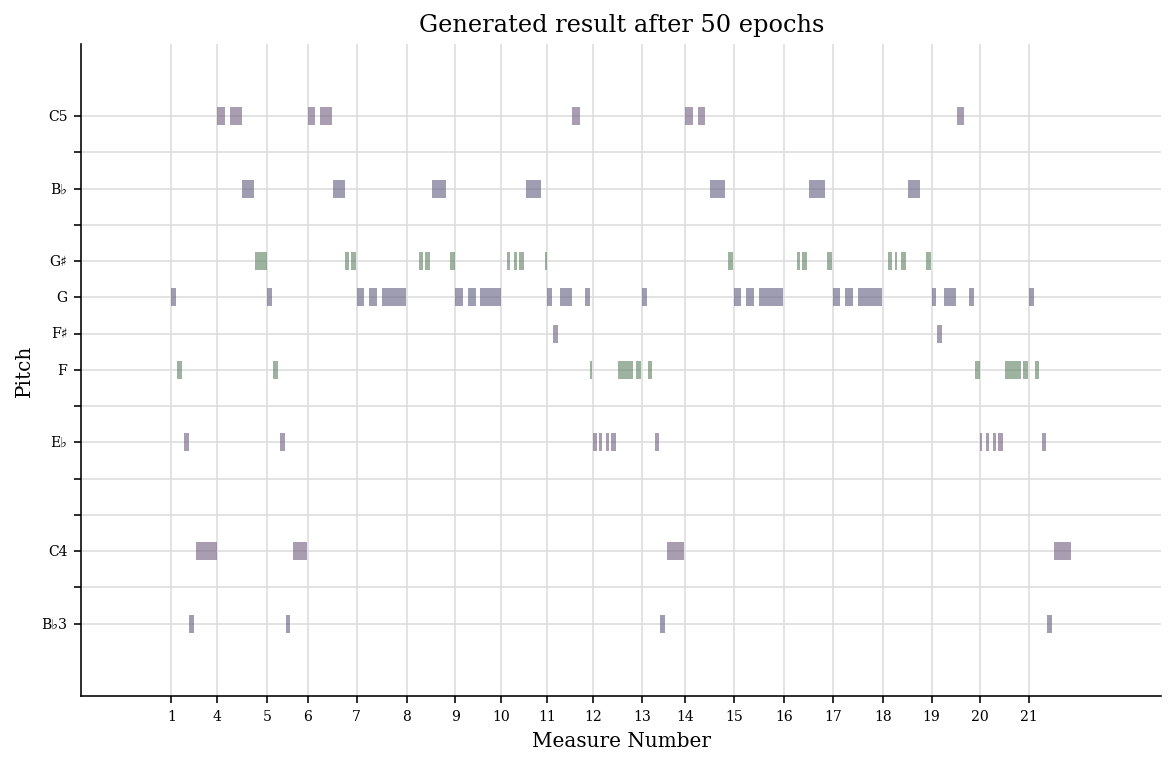

In [ ]:
generated_df = pd.concat([context_df, generated_df], axis=0)
generated = decode_data(generated_df, N_FRAMES)

expected.plot(title='Expected result')
generated.plot(title=f'Generated result after {N_EPOCHS} epochs')
